https://github.com/Regressionist/Stock-prediction-Dual-Attention-based-RNN-

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from modules import Encoder, Decoder

In [2]:
train_df=pd.read_csv('data/train.csv')
validation_df=pd.read_csv('data/validation.csv')
validation_df=pd.concat([train_df[-9:],validation_df])
validation_df=validation_df.reset_index(drop=True)
test_df=pd.read_csv('data/test.csv')
train_df.drop(['High', 'Low', 'Timestamp'],axis=1,inplace=True)
validation_df.drop(['High', 'Low', 'Timestamp'],axis=1,inplace=True)
test_df.drop(['High', 'Low','Timestamp'],axis=1,inplace=True)

In [3]:
class dataprep(Dataset):
    def __init__(self, dataframe):
        self.df=dataframe
    def __len__(self):
        return self.df.shape[0]-10
    def __getitem__(self,idx):
        if (idx+10<self.df.shape[0]):
            X=torch.from_numpy(self.df.drop('Close',axis=1)[idx:idx+10].values)
            targets=torch.from_numpy(self.df['Close'][idx:idx+9].values)
            y=torch.tensor([self.df['Close'].loc[idx+9]])
            return ({'X':X, 'targets':targets, 'y': y})

In [4]:
train_set=dataprep(dataframe=train_df)
validation_set=dataprep(dataframe=validation_df)
test_set=dataprep(dataframe=test_df)

In [5]:
for i in range(60,63):
    sample=validation_set[i]
    print (i,sample['X'].size(),sample['targets'].size(), sample['y'].size())

60 torch.Size([10, 2]) torch.Size([9]) torch.Size([1])
61 torch.Size([10, 2]) torch.Size([9]) torch.Size([1])
62 torch.Size([10, 2]) torch.Size([9]) torch.Size([1])


In [6]:
len(train_set)

9613

In [7]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [8]:
def train(encoder,decoder,encoder_optimizer, decoder_optimizer, train_loader, loss_criterion, rl, num_epochs, epoch, epochs):
    running_loss=0
    for i, sample in enumerate(train_loader):
        x=Variable(sample['X'].type(torch.FloatTensor))
        y=Variable(sample['targets'].type(torch.FloatTensor))
        y_true=Variable(sample['y'].type(torch.FloatTensor))
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
#        hidden=encoder.initHidden(16)
        weighted_, encoded=encoder(x)
#        hidden=decoder.initHidden(16)
#        y_pred=decoder(encoded,y,16,hidden)
        y_pred=decoder(encoded,y)
        
        loss=loss_criterion(y_pred,y_true)
        running_loss+=loss.item()
        rl.append(loss.item())
        
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        
    print('Epoch: {}/{} | Loss: {}'.format(epoch-epochs+1, num_epochs, running_loss))
            

In [9]:
def pp(y_pred,y_true):
    r=0
    for t in range(0,len(y_pred)-1):
        if((y_pred[t+1]>=y_pred[t] and y_true[t+1]>=y_true[t]) or (y_pred[t+1]<y_pred[t] and y_true[t+1]<y_true[t])):
            r=r+1
    return r/len(y_pred)

In [10]:
def evaluate(encoder,decoder, val_loader, loss_criterion, num_epochs, epoch, epochs):
    eval_loss=0
    y_predicted=[]
    y_actual=[]
    with torch.no_grad():
        for i,sample in enumerate(val_loader):
            x=sample['X'].type(torch.FloatTensor)
            y=sample['targets'].type(torch.FloatTensor)
            y_true=sample['y'].type(torch.FloatTensor)
            
 #           hidden=encoder.initHidden(1)
            weighted_, encoded=encoder(x)
#            hidden=decoder.initHidden(1)
            y_pred=decoder(encoded,y)
        
            loss=loss_criterion(y_pred,y_true)
            eval_loss+=loss.item()
            y_predicted.append(y_pred.item())
            y_actual.append(y_true.item())
            
        pred_perf=pp(y_predicted, y_actual)
    print('Epoch: {}/{} | Evaluation_Loss: {} | Pred. Power: {}'.format(epoch-epochs+1, num_epochs, eval_loss, pred_perf))        
    plt.plot(range(len(y_predicted)),y_predicted,color='red')
    plt.plot(range(len(y_actual)),y_actual,color='blue')
    #print(len(y_predicted),len(y_actual))
    plt.show()
    
    
    return eval_loss,pred_perf

In [11]:
encoder=Encoder(input_size = 2, hidden_size=16, T = 1)
decoder = Decoder(encoder_hidden_size = 16, decoder_hidden_size = 16, T =1)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [12]:
encoder_optimizer = optim.Adam(encoder.parameters())
decoder_optimizer = optim.Adam(decoder.parameters())
criterion=nn.MSELoss()

Epoch: 1/20 | Loss: 10.962092638306785
Epoch: 1/20 | Evaluation_Loss: 102.13296711817384 | Pred. Power: 0.5131004366812227


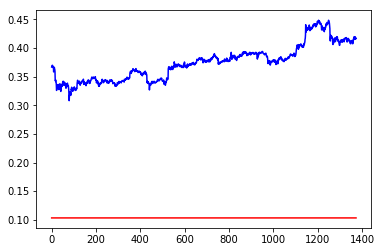

eval_loss: 102.13296711817384  pred_perf: 0.5131004366812227
Epoch: 2/20 | Loss: 4.354180823604111
Epoch: 2/20 | Evaluation_Loss: 102.63295764476061 | Pred. Power: 0.5131004366812227


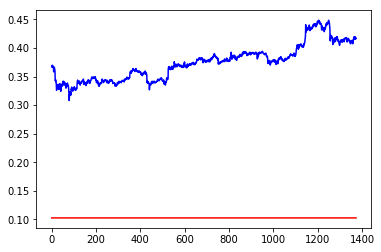

eval_loss: 102.63295764476061  pred_perf: 0.5131004366812227
Epoch: 3/20 | Loss: 4.352805438655196
Epoch: 3/20 | Evaluation_Loss: 96.82176146283746 | Pred. Power: 0.5131004366812227


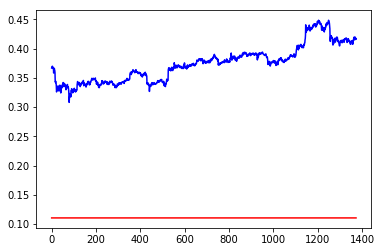

eval_loss: 96.82176146283746  pred_perf: 0.5131004366812227
Epoch: 4/20 | Loss: 4.352771568286698
Epoch: 4/20 | Evaluation_Loss: 103.52316848188639 | Pred. Power: 0.5131004366812227


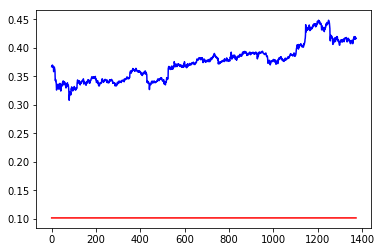

eval_loss: 103.52316848188639  pred_perf: 0.5131004366812227
Epoch: 5/20 | Loss: 4.35625867365161
Epoch: 5/20 | Evaluation_Loss: 98.36039494350553 | Pred. Power: 0.5131004366812227


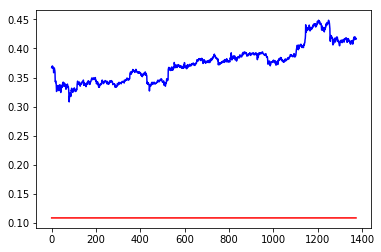

eval_loss: 98.36039494350553  pred_perf: 0.5131004366812227
Epoch: 6/20 | Loss: 4.355384439986665
Epoch: 6/20 | Evaluation_Loss: 101.76462072134018 | Pred. Power: 0.5131004366812227


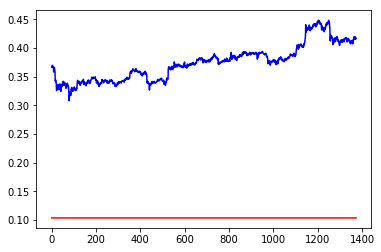

eval_loss: 101.76462072134018  pred_perf: 0.5131004366812227
Epoch: 7/20 | Loss: 4.359603911230806
Epoch: 7/20 | Evaluation_Loss: 100.69899666681886 | Pred. Power: 0.5131004366812227


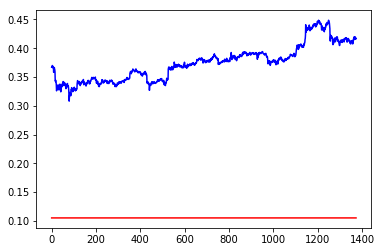

eval_loss: 100.69899666681886  pred_perf: 0.5131004366812227
Epoch: 8/20 | Loss: 4.357602872885764
Epoch: 8/20 | Evaluation_Loss: 98.72631181403995 | Pred. Power: 0.5131004366812227


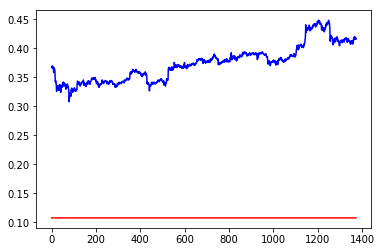

eval_loss: 98.72631181403995  pred_perf: 0.5131004366812227
Epoch: 9/20 | Loss: 4.353882416791748
Epoch: 9/20 | Evaluation_Loss: 100.1842316351831 | Pred. Power: 0.5131004366812227


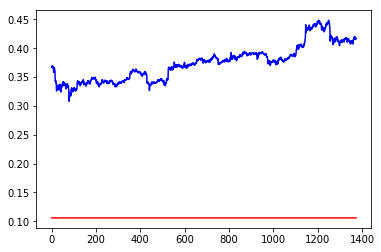

eval_loss: 100.1842316351831  pred_perf: 0.5131004366812227
Epoch: 10/20 | Loss: 4.356876800768077
Epoch: 10/20 | Evaluation_Loss: 103.81875327974558 | Pred. Power: 0.5131004366812227


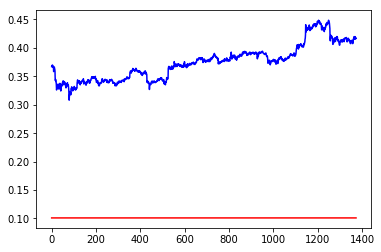

eval_loss: 103.81875327974558  pred_perf: 0.5131004366812227
Epoch: 11/20 | Loss: 4.358625716762617
Epoch: 11/20 | Evaluation_Loss: 99.54039331153035 | Pred. Power: 0.5131004366812227


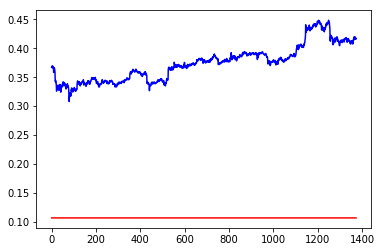

eval_loss: 99.54039331153035  pred_perf: 0.5131004366812227
Epoch: 12/20 | Loss: 4.3501560149597935
Epoch: 12/20 | Evaluation_Loss: 101.17614746466279 | Pred. Power: 0.5131004366812227


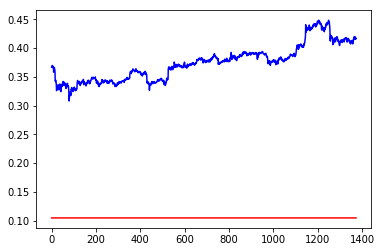

eval_loss: 101.17614746466279  pred_perf: 0.5131004366812227
Epoch: 13/20 | Loss: 4.356108653359115
Epoch: 13/20 | Evaluation_Loss: 100.1638453528285 | Pred. Power: 0.5131004366812227


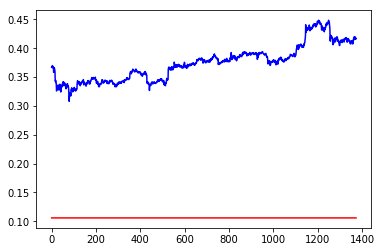

eval_loss: 100.1638453528285  pred_perf: 0.5131004366812227
Epoch: 14/20 | Loss: 4.359207724628504
Epoch: 14/20 | Evaluation_Loss: 98.53904075920582 | Pred. Power: 0.5131004366812227


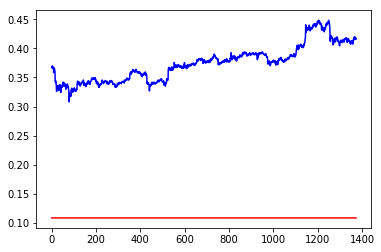

eval_loss: 98.53904075920582  pred_perf: 0.5131004366812227
Epoch: 15/20 | Loss: 4.352174258034211
Epoch: 15/20 | Evaluation_Loss: 104.78444596379995 | Pred. Power: 0.5131004366812227


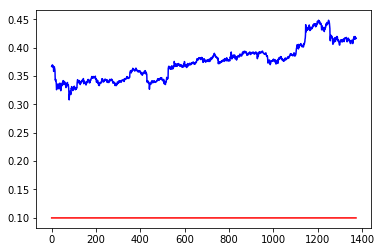

eval_loss: 104.78444596379995  pred_perf: 0.5131004366812227
Epoch: 16/20 | Loss: 4.358037834754214
Epoch: 16/20 | Evaluation_Loss: 101.73865838348866 | Pred. Power: 0.5131004366812227


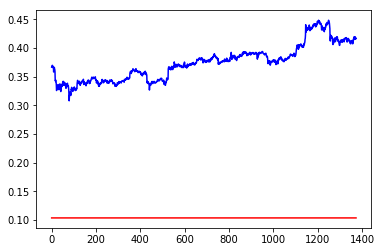

eval_loss: 101.73865838348866  pred_perf: 0.5131004366812227
Epoch: 17/20 | Loss: 4.355205369240139
Epoch: 17/20 | Evaluation_Loss: 101.9072558619082 | Pred. Power: 0.5131004366812227


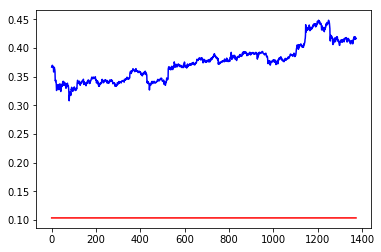

eval_loss: 101.9072558619082  pred_perf: 0.5131004366812227
Epoch: 18/20 | Loss: 4.361388474062551
Epoch: 18/20 | Evaluation_Loss: 100.8825256228447 | Pred. Power: 0.5131004366812227


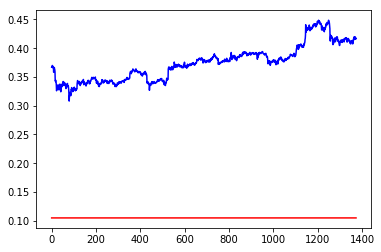

eval_loss: 100.8825256228447  pred_perf: 0.5131004366812227
Epoch: 19/20 | Loss: 4.356457567890175
Epoch: 19/20 | Evaluation_Loss: 100.81255179643631 | Pred. Power: 0.5131004366812227


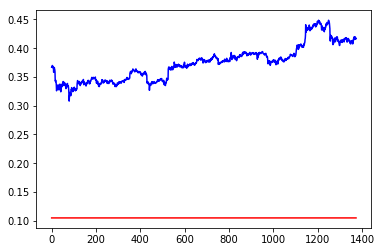

eval_loss: 100.81255179643631  pred_perf: 0.5131004366812227
Epoch: 20/20 | Loss: 4.358695874398109
Epoch: 20/20 | Evaluation_Loss: 102.69831846654415 | Pred. Power: 0.5131004366812227


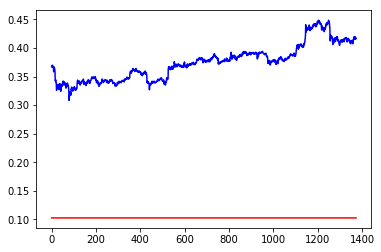

eval_loss: 102.69831846654415  pred_perf: 0.5131004366812227


In [13]:
rl=[]
num_epochs=20
epochs=0
for epoch in range(epochs,epochs+num_epochs):
    train(encoder,decoder,encoder_optimizer, decoder_optimizer,train_loader,criterion,rl,num_epochs, epoch, epochs)
    eval_loss, pred_perf=evaluate(encoder,decoder, val_loader, criterion, num_epochs, epoch, epochs)
    print('eval_loss: {}  pred_perf: {}'.format(eval_loss, pred_perf))
    if (eval_loss<0.01 and pred_perf>0.5):
        print ('%---Saving the model---%')
        torch.save({
            'epoch': epoch+1,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': rl,
            },'models/OpenPrice/model_{}.pth'.format(epoch+1))
    

In [14]:
%matplotlib notebook

eval_loss=0
y_predicted=[]
y_actual=[]
with torch.no_grad():
    for i,sample in enumerate(val_loader):
        x=sample['X'].type(torch.FloatTensor)
        y=sample['targets'].type(torch.FloatTensor)
        y_true=sample['y'].type(torch.FloatTensor)
            
 #       hidden=encoder.initHidden(1)
        encoded=encoder(x)
#        hidden=decoder.initHidden(1)
        y_pred=decoder(encoded,y)
        
        loss=loss_criterion(y_pred,y_true)
        eval_loss+=loss.item()
        y_predicted.append(y_pred.item())
        y_actual.append(y_true.item())
            
        pred_perf=pp(y_predicted, y_actual)
print('Epoch: {}/{} | Evaluation_Loss: {} | Pred. Power: {}'.format(epoch-epochs+1, num_epochs, eval_loss, pred_perf))        
plt.plot(range(len(y_predicted)),y_predicted,color='red')
plt.plot(range(len(y_actual)),y_actual,color='blue')
#print(len(y_predicted),len(y_actual))
plt.show()

TypeError: forward() takes 2 positional arguments but 3 were given